In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import scipy.stats as stats


## Model 1
Main Idea: Use *multiple linear regression* to predict how many points a team will get in the next season. This should be a purely statistical way to predict how a team will perform and it shouldn't matter "which" team it is. Any team with x of feature 1, y of feature 2, z of feature 3, and so on should have an output of n number of points.  

### Key Points
- a teams "pedigree" and "history" should not affect the model outputs
Model: f(x1, x2, ... , xn) = ax1 + bx2 + ... + nxn + e
- the name of the team CANNOT be in the inputs

---
### Step 1 - Data Preparation

Since we are 
(1) only using statistics available to us BEFORE the season begins
(2) making team based predictions without considering players
(3) not using pedigree and history to define out outcomes

This means we cannot use any team or player match related statistics, previous fixtures, and almost all the data we have collected. We can only use transfermarkt_raw_data.csv which contains very high level data.


In [2]:
raw_data = pd.read_csv("/Users/apendela10/STAT482/statistics-capstone/results/transfermarkt_data_raw.csv")
raw_data.describe()


,Squad_Size,Average_Age,Number_of_Foreigners,Average_Market_Value,Total_Market_Value,Position,Goal_Difference,Points,Year
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.00000,440.000000,440.000000
mean,37.552273,25.953636,23.454545,8.504277,319.507727,10.500000,0.00000,50.245455,2014.500000
std,5.589365,1.175678,5.144183,7.643674,280.114760,5.772845,26.49107,19.744005,6.351511
min,23.000000,22.200000,11.000000,0.767000,31.050000,1.000000,-69.00000,0.000000,2004.000000
25%,34.000000,25.200000,20.000000,3.030000,109.537500,5.750000,-19.00000,39.000000,2009.000000
50%,37.000000,25.900000,23.000000,6.170000,232.015000,10.500000,-4.00000,47.000000,2014.500000
75%,41.000000,26.800000,27.000000,11.532500,426.612500,15.250000,15.00000,63.000000,2020.000000
max,58.000000,29.200000,41.000000,53.000000,1460.000000,20.000000,79.00000,100.000000,2025.000000


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Team                  440 non-null    object 
 1   Squad_Size            440 non-null    int64  
 2   Average_Age           440 non-null    float64
 3   Number_of_Foreigners  440 non-null    int64  
 4   Average_Market_Value  440 non-null    float64
 5   Total_Market_Value    440 non-null    float64
 6   Position              440 non-null    int64  
 7   Goal_Difference       440 non-null    int64  
 8   Points                440 non-null    int64  
 9   Year                  440 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 34.5+ KB


This means that we have **440** data points, consisting of **20 teams** each year for **22 years**. For each team and each year, we have
squad size, average age, number of foreigners, average market value, total market value, position, goal difference, points and year. 

However, position, goal difference, and points are output variables. Points is the output variable we want to predict. This is the Y.

We are left with squad size, average age, number of foreigners, average market value, total market value. These are all known at the beginning of the season and can be used to predict points. Its now time to visualize these specific data and apply normalization techniques. 

Fundamentally, there is a lot more variation than this to predict points but the models become far more complex for that as well. This is meant to be a simple baseline.



---
## EDA for Model 1

Features:   
(1) squad_size  
(2) average_age  
(3) number_of_foreigners  
(4) average_market_value  
(5) total_market_value  
 
Outputs:   
(1) Points

#### (1) Squad Size

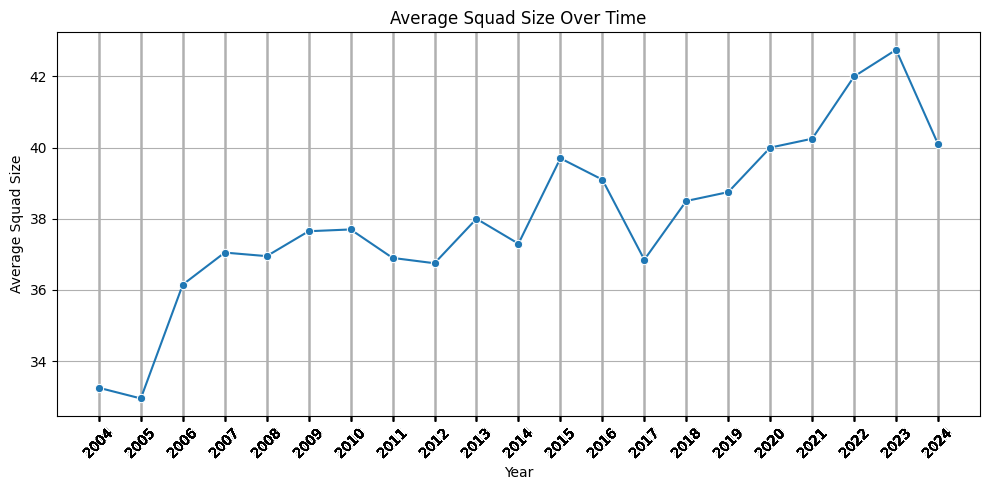

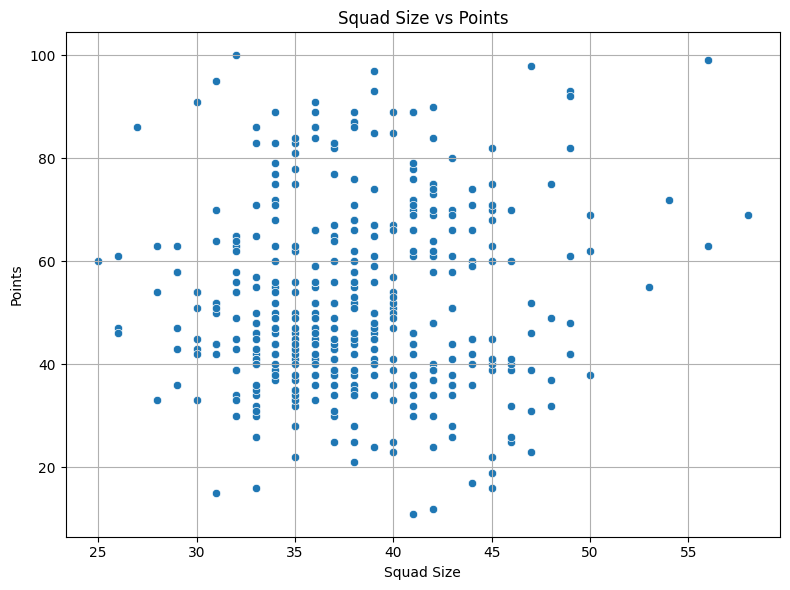

Pearson correlation coefficient: 0.062


In [4]:
raw_data_excl_25 = raw_data[raw_data["Year"] != 2025]

# 1. Plot: Squad Size over time
plt.figure(figsize=(10, 5))
avg_squad = raw_data_excl_25.groupby('Year')['Squad_Size'].mean().reset_index()
sns.lineplot(data=avg_squad, x='Year', y='Squad_Size', marker='o')
plt.title('Average Squad Size Over Time')
plt.xlabel('Year')
plt.ylabel('Average Squad Size')
plt.xticks(ticks=raw_data_excl_25['Year'], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Plot: Squad Size vs Points
plt.figure(figsize=(8, 6))
sns.scatterplot(data=raw_data_excl_25, x='Squad_Size', y='Points')
plt.title('Squad Size vs Points')
plt.xlabel('Squad Size')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Pearson Correlation
corr, p_value = pearsonr(raw_data_excl_25['Squad_Size'], raw_data_excl_25['Points'])
print(f"Pearson correlation coefficient: {corr:.3f}")

Remarks: Loooks like squad size is not at all a real indicator of success and probably isnt a good predictor! Also, squad sizes have generally increased over the years, showing that they may need to be normalized. 

In [5]:
avg_per_year = raw_data_excl_25.groupby('Year')['Squad_Size'].transform('mean')
raw_data_excl_25['Squad_Size_Normalized_by_Avg'] = raw_data_excl_25['Squad_Size'] / avg_per_year

max_per_year = raw_data_excl_25.groupby('Year')['Squad_Size'].transform('max')
raw_data_excl_25['Squad_Size_Normalized_by_Max'] = raw_data_excl_25['Squad_Size'] / max_per_year


/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/1309984788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Squad_Size_Normalized_by_Avg'] = raw_data_excl_25['Squad_Size'] / avg_per_year
/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/1309984788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Squad_Size_Normalized_by_Max'] = raw_data_excl_25['Squad_Size'] / max_per_year


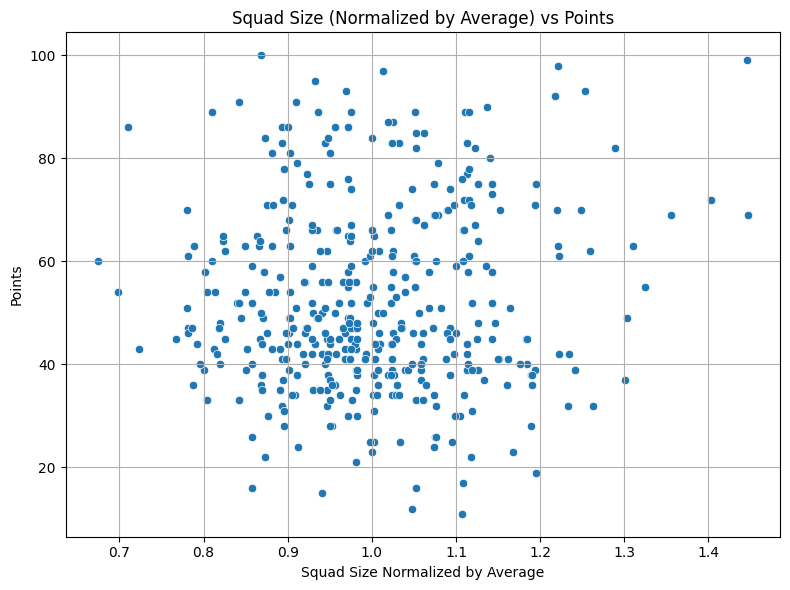

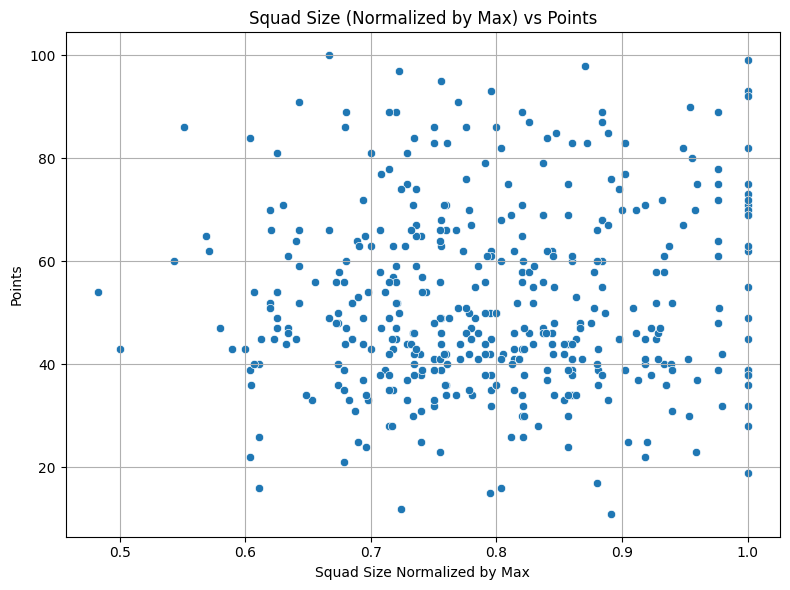

Correlation (Normalized by Avg) vs Points: 0.068
Correlation (Normalized by Max) vs Points: 0.050


In [6]:
# Scatter plot: Normalized by Average
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Squad_Size_Normalized_by_Avg'], y=raw_data_excl_25['Points'])
plt.title('Squad Size (Normalized by Average) vs Points')
plt.xlabel('Squad Size Normalized by Average')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot: Normalized by Max
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Squad_Size_Normalized_by_Max'], y=raw_data_excl_25['Points'])
plt.title('Squad Size (Normalized by Max) vs Points')
plt.xlabel('Squad Size Normalized by Max')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation: Normalized by Average
corr_avg, p_avg = pearsonr(raw_data_excl_25['Squad_Size_Normalized_by_Avg'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Avg) vs Points: {corr_avg:.3f}")

# Pearson correlation: Normalized by Max
corr_max, p_max = pearsonr(raw_data_excl_25['Squad_Size_Normalized_by_Max'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Max) vs Points: {corr_max:.3f}")

TLDR: Squad size doesnt really seem too useful. 

### (2) Average Age

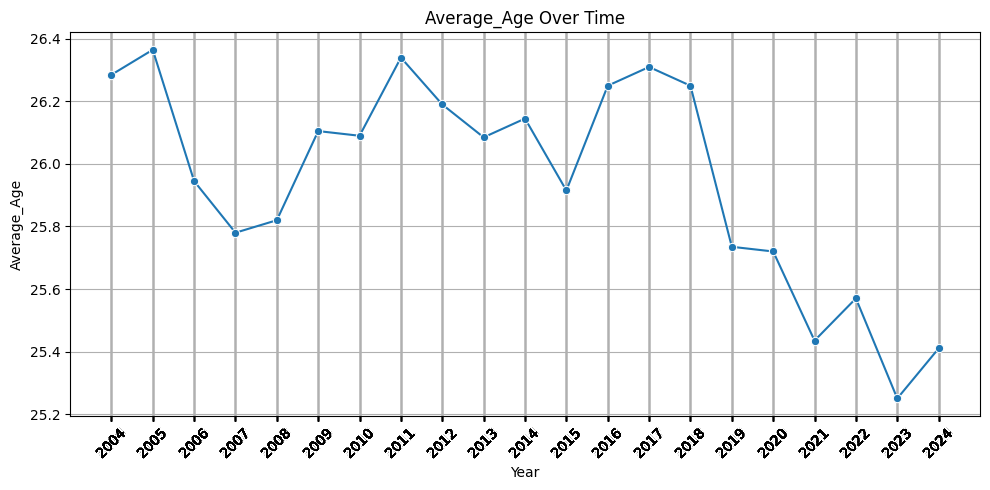

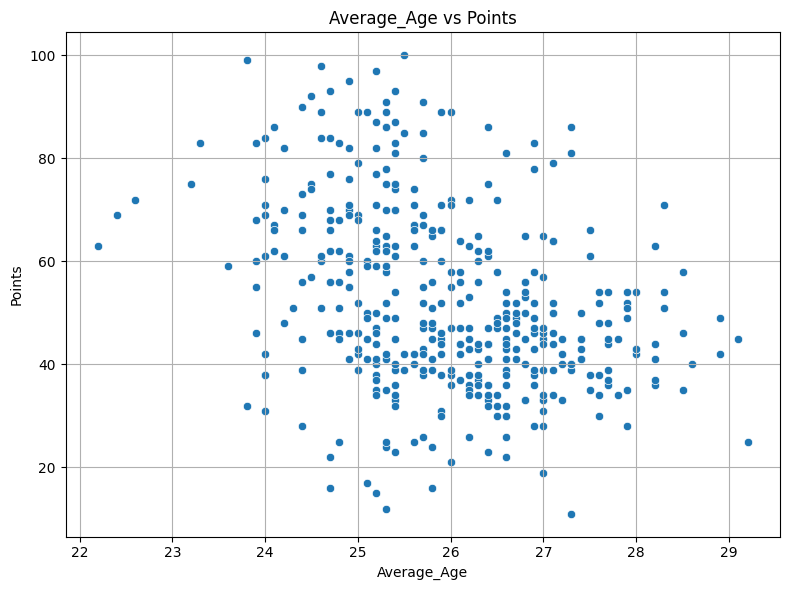

Pearson correlation coefficient: -0.354


In [7]:
# 1. Plot: Average Age over time
plt.figure(figsize=(10, 5))
avg_squad = raw_data_excl_25.groupby('Year')['Average_Age'].mean().reset_index()
sns.lineplot(data=avg_squad, x='Year', y='Average_Age', marker='o')
plt.title('Average_Age Over Time')
plt.xlabel('Year')
plt.ylabel('Average_Age')
plt.xticks(ticks=raw_data_excl_25['Year'], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Plot: Average Age vs Points
plt.figure(figsize=(8, 6))
sns.scatterplot(data=raw_data_excl_25, x='Average_Age', y='Points')
plt.title('Average_Age vs Points')
plt.xlabel('Average_Age')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Pearson Correlation
corr, p_value = pearsonr(raw_data_excl_25['Average_Age'], raw_data_excl_25['Points'])
print(f"Pearson correlation coefficient: {corr:.3f}")

Remarks: Looks like squad size has been getting younger over time with a correlation of around -0.35. Normalizing might help again!

In [8]:
avg_per_year = raw_data_excl_25.groupby('Year')['Average_Age'].transform('mean')
raw_data_excl_25['Average_Age_Normalized_by_Avg'] = raw_data_excl_25['Average_Age'] / avg_per_year

max_per_year = raw_data_excl_25.groupby('Year')['Average_Age'].transform('max')
raw_data_excl_25['Average_Age_Normalized_by_Max'] = raw_data_excl_25['Average_Age'] / max_per_year


/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/1668496780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Average_Age_Normalized_by_Avg'] = raw_data_excl_25['Average_Age'] / avg_per_year
/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/1668496780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Average_Age_Normalized_by_Max'] = raw_data_excl_25['Average_Age'] / max_per_year


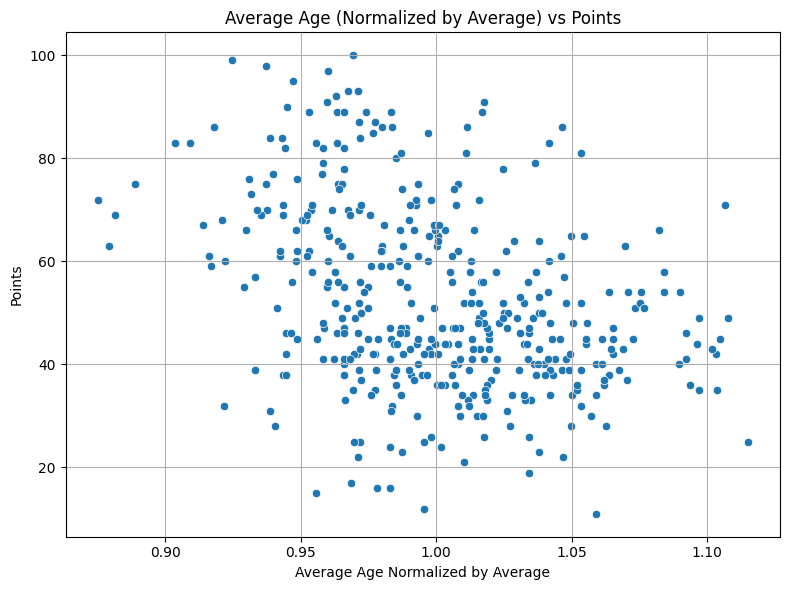

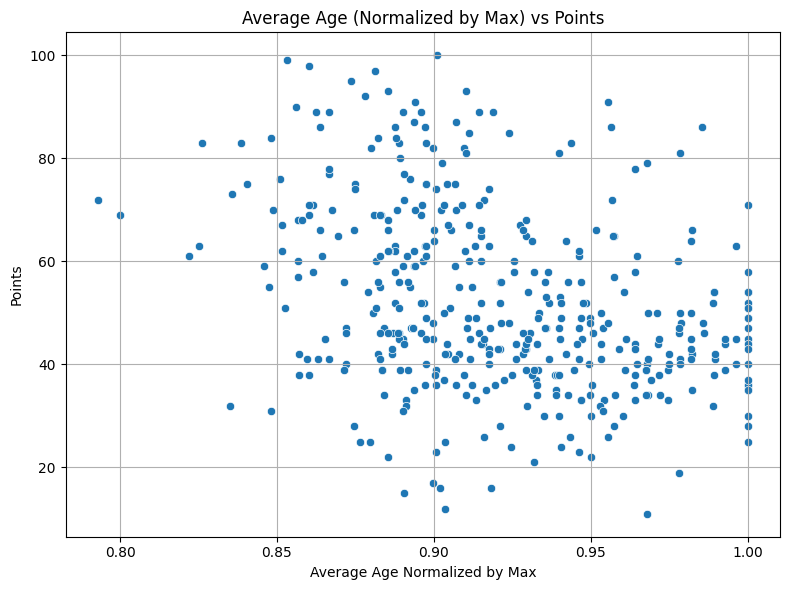

Correlation (Normalized by Avg) vs Points: -0.367
Correlation (Normalized by Max) vs Points: -0.345


In [9]:
# Scatter plot: Normalized by Average
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Average_Age_Normalized_by_Avg'], y=raw_data_excl_25['Points'])
plt.title('Average Age (Normalized by Average) vs Points')
plt.xlabel('Average Age Normalized by Average')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot: Normalized by Max
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Average_Age_Normalized_by_Max'], y=raw_data_excl_25['Points'])
plt.title('Average Age (Normalized by Max) vs Points')
plt.xlabel('Average Age Normalized by Max')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation: Normalized by Average
corr_avg, p_avg = pearsonr(raw_data_excl_25['Average_Age_Normalized_by_Avg'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Avg) vs Points: {corr_avg:.3f}")

# Pearson correlation: Normalized by Max
corr_max, p_max = pearsonr(raw_data_excl_25['Average_Age_Normalized_by_Max'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Max) vs Points: {corr_max:.3f}")

### (3) Number of Foreigners

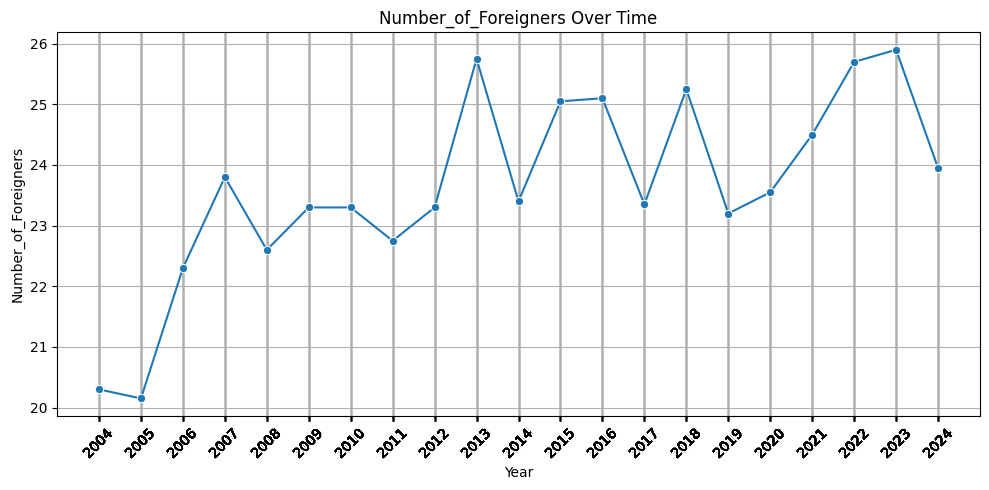

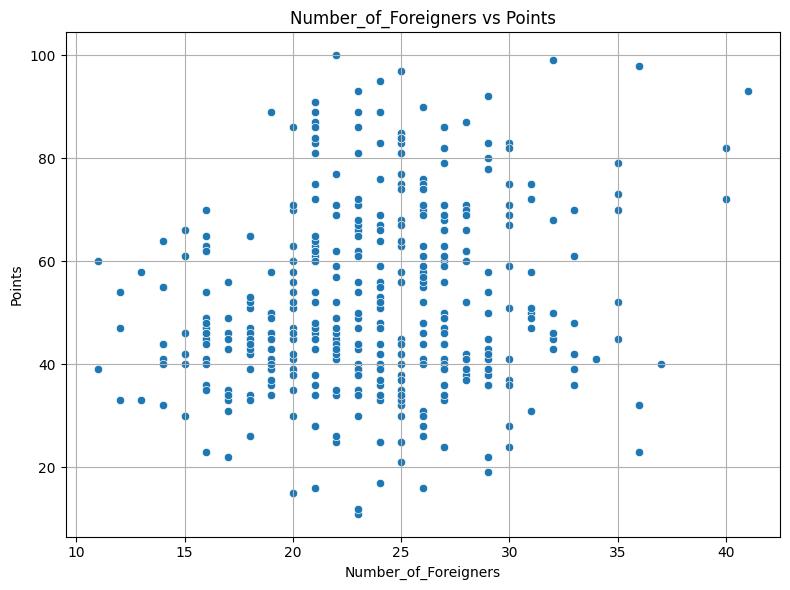

Pearson correlation coefficient: 0.167


In [10]:
# 1. Plot: Average Age over time
plt.figure(figsize=(10, 5))
avg_squad = raw_data_excl_25.groupby('Year')['Number_of_Foreigners'].mean().reset_index()
sns.lineplot(data=avg_squad, x='Year', y='Number_of_Foreigners', marker='o')
plt.title('Number_of_Foreigners Over Time')
plt.xlabel('Year')
plt.ylabel('Number_of_Foreigners')
plt.grid(True)
plt.xticks(ticks=raw_data_excl_25['Year'], rotation=45)
plt.tight_layout()
plt.show()

# 2. Plot: Average Age vs Points
plt.figure(figsize=(8, 6))
sns.scatterplot(data=raw_data_excl_25, x='Number_of_Foreigners', y='Points')
plt.title('Number_of_Foreigners vs Points')
plt.xlabel('Number_of_Foreigners')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Pearson Correlation
corr, p_value = pearsonr(raw_data_excl_25['Number_of_Foreigners'], raw_data_excl_25['Points'])
print(f"Pearson correlation coefficient: {corr:.3f}")

Remarks: Yet again it seems like normalization may be helpful!

In [11]:
avg_per_year = raw_data_excl_25.groupby('Year')['Number_of_Foreigners'].transform('mean')
raw_data_excl_25['Number_of_Foreigners_Normalized_by_Avg'] = raw_data_excl_25['Number_of_Foreigners'] / avg_per_year

max_per_year = raw_data_excl_25.groupby('Year')['Number_of_Foreigners'].transform('max')
raw_data_excl_25['Number_of_Foreigners_Normalized_by_Max'] = raw_data_excl_25['Number_of_Foreigners'] / max_per_year


/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/4099481256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Number_of_Foreigners_Normalized_by_Avg'] = raw_data_excl_25['Number_of_Foreigners'] / avg_per_year
/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/4099481256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Number_of_Foreigners_Normalized_by_Max'] = raw_data_excl_25['Number_of_Foreigners'] / max_per_year


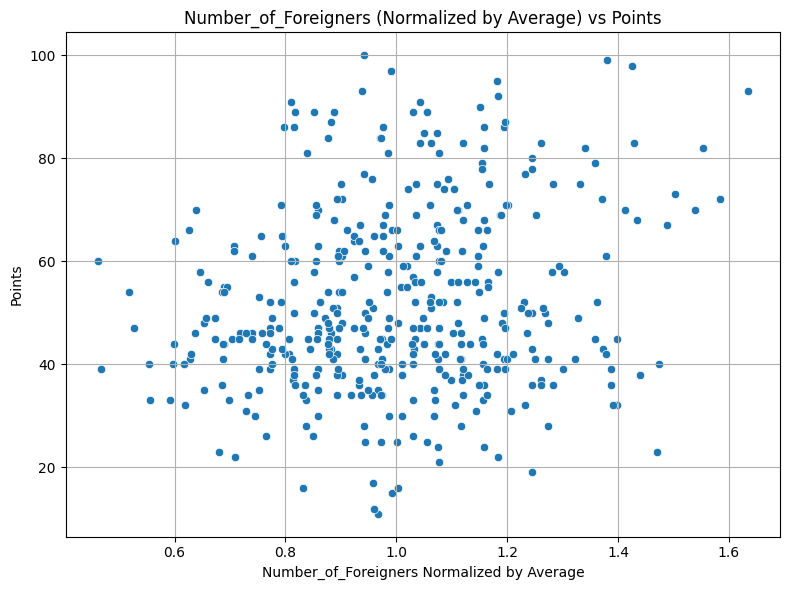

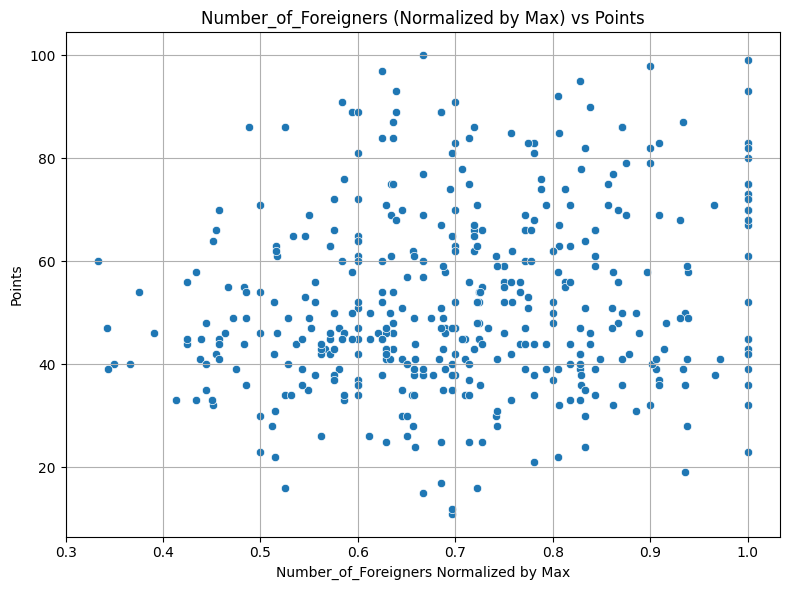

Correlation (Normalized by Avg) vs Points: 0.178
Correlation (Normalized by Max) vs Points: 0.163


In [12]:
# Scatter plot: Normalized by Average
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Number_of_Foreigners_Normalized_by_Avg'], y=raw_data_excl_25['Points'])
plt.title('Number_of_Foreigners (Normalized by Average) vs Points')
plt.xlabel('Number_of_Foreigners Normalized by Average')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot: Normalized by Max
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Number_of_Foreigners_Normalized_by_Max'], y=raw_data_excl_25['Points'])
plt.title('Number_of_Foreigners (Normalized by Max) vs Points')
plt.xlabel('Number_of_Foreigners Normalized by Max')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation: Normalized by Average
corr_avg, p_avg = pearsonr(raw_data_excl_25['Number_of_Foreigners_Normalized_by_Avg'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Avg) vs Points: {corr_avg:.3f}")

# Pearson correlation: Normalized by Max
corr_max, p_max = pearsonr(raw_data_excl_25['Number_of_Foreigners_Normalized_by_Max'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Max) vs Points: {corr_max:.3f}")

### (4) Average_Market_Value

This is the average market value of a player in a particular club's squad for a particular year at the start of the season. Obviously, this may confound with Squad_Size since average_market_value = total_market_value / squad_size

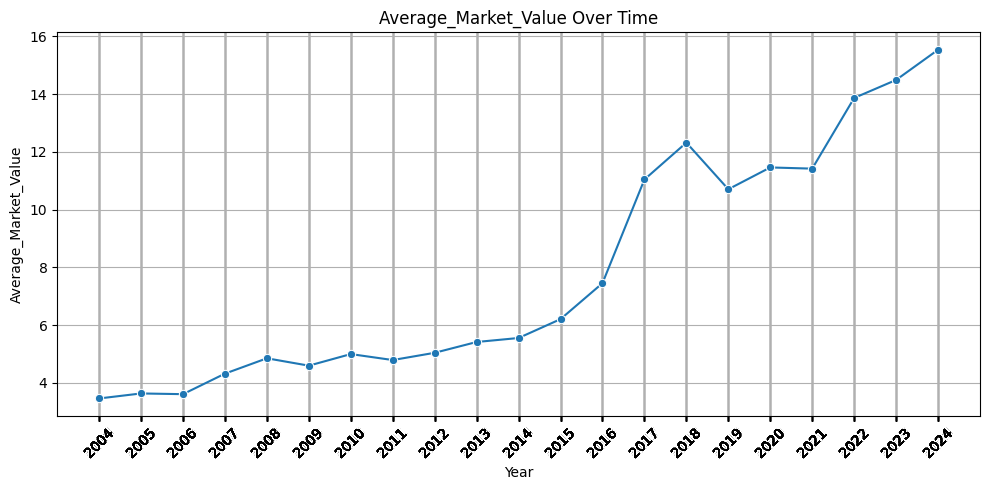

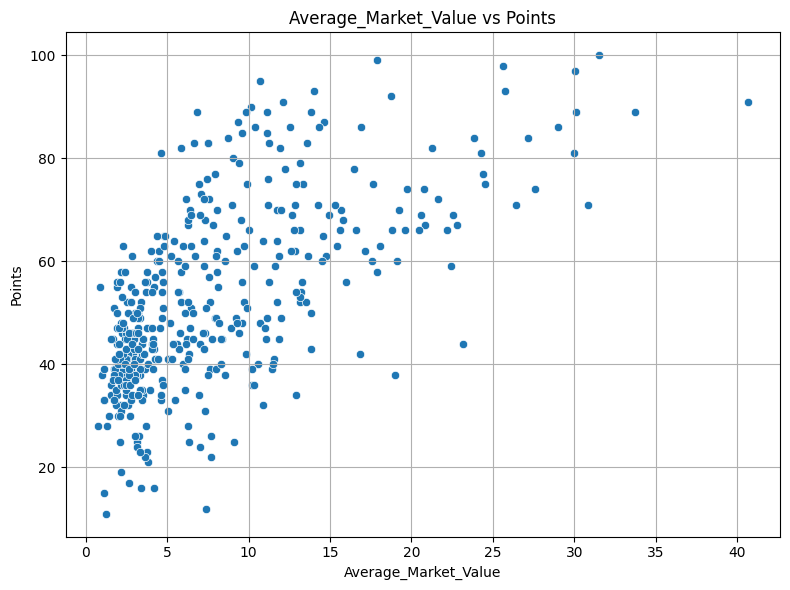

Pearson correlation coefficient: 0.641


In [13]:
# 1. Plot: Average_Market_Value over time
plt.figure(figsize=(10, 5))
avg_squad = raw_data_excl_25.groupby('Year')['Average_Market_Value'].mean().reset_index()
sns.lineplot(data=avg_squad, x='Year', y='Average_Market_Value', marker='o')
plt.title('Average_Market_Value Over Time')
plt.xlabel('Year')
plt.ylabel('Average_Market_Value')
plt.grid(True)
plt.xticks(ticks=raw_data_excl_25['Year'], rotation=45)
plt.tight_layout()
plt.show()

# 2. Plot: Average_Market_Value vs Points
plt.figure(figsize=(8, 6))
sns.scatterplot(data=raw_data_excl_25, x='Average_Market_Value', y='Points')
plt.title('Average_Market_Value vs Points')
plt.xlabel('Average_Market_Value')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Pearson Correlation
corr, p_value = pearsonr(raw_data_excl_25['Average_Market_Value'], raw_data_excl_25['Points'])
print(f"Pearson correlation coefficient: {corr:.3f}")

Clearly in financial statistics, inflation will play a huge role and average and max based normalization may help this a lot. 

In [14]:
avg_per_year = raw_data_excl_25.groupby('Year')['Average_Market_Value'].transform('mean')
raw_data_excl_25['Average_Market_Value_Normalized_by_Avg'] = raw_data_excl_25['Average_Market_Value'] / avg_per_year

max_per_year = raw_data_excl_25.groupby('Year')['Average_Market_Value'].transform('max')
raw_data_excl_25['Average_Market_Value_Normalized_by_Max'] = raw_data_excl_25['Average_Market_Value'] / max_per_year


/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/3319881244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Average_Market_Value_Normalized_by_Avg'] = raw_data_excl_25['Average_Market_Value'] / avg_per_year
/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/3319881244.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Average_Market_Value_Normalized_by_Max'] = raw_data_excl_25['Average_Market_Value'] / max_per_year


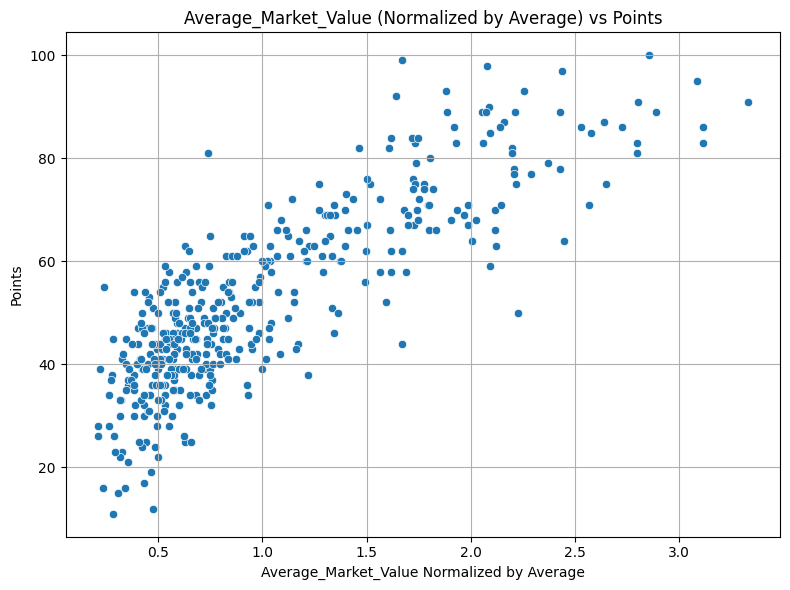

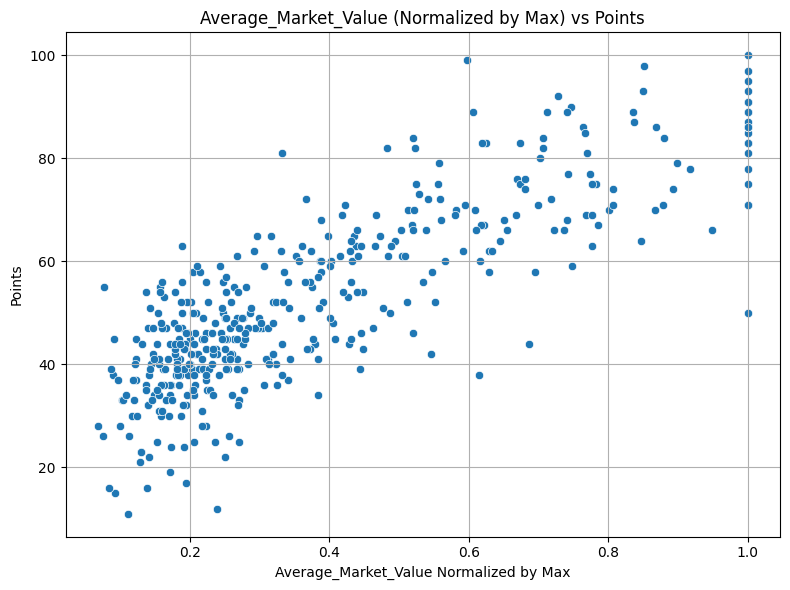

Correlation (Normalized by Avg) vs Points: 0.843
Correlation (Normalized by Max) vs Points: 0.828


In [15]:
# Scatter plot: Normalized by Average
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Average_Market_Value_Normalized_by_Avg'], y=raw_data_excl_25['Points'])
plt.title('Average_Market_Value (Normalized by Average) vs Points')
plt.xlabel('Average_Market_Value Normalized by Average')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot: Normalized by Max
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Average_Market_Value_Normalized_by_Max'], y=raw_data_excl_25['Points'])
plt.title('Average_Market_Value (Normalized by Max) vs Points')
plt.xlabel('Average_Market_Value Normalized by Max')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation: Normalized by Average
corr_avg, p_avg = pearsonr(raw_data_excl_25['Average_Market_Value_Normalized_by_Avg'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Avg) vs Points: {corr_avg:.3f}")

# Pearson correlation: Normalized by Max
corr_max, p_max = pearsonr(raw_data_excl_25['Average_Market_Value_Normalized_by_Max'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Max) vs Points: {corr_max:.3f}")

As we saw for previous statistics, normalizing by the average seems to be more effective. 

### (5) Total_Market_Value

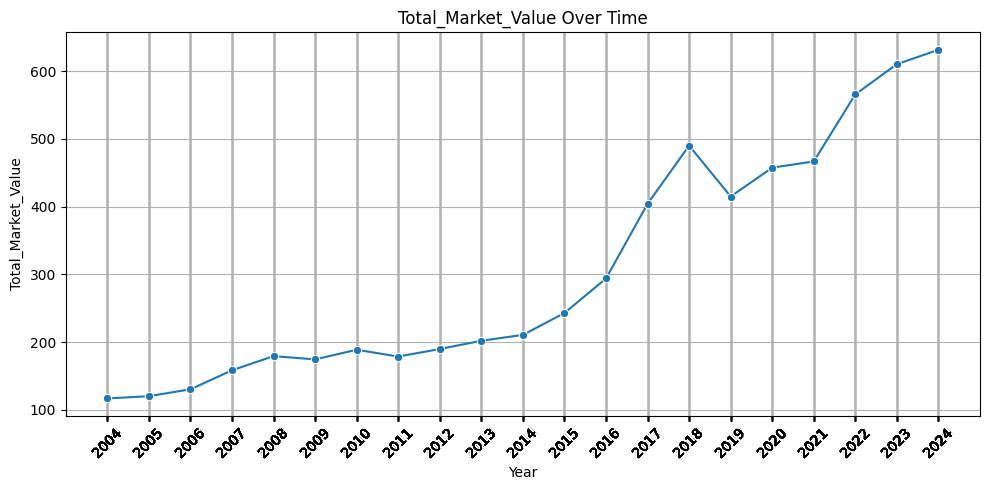

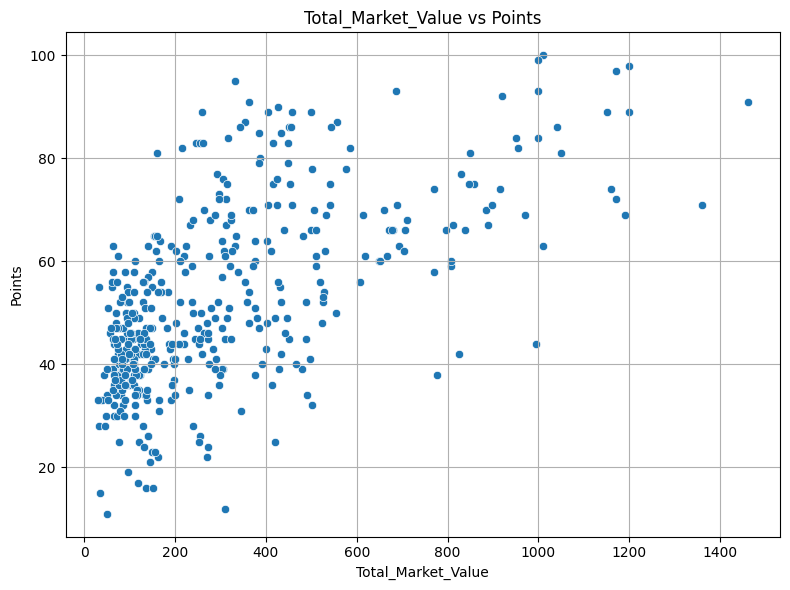

Pearson correlation coefficient: 0.620


In [16]:
# 1. Plot: Total_Market_Value over time
plt.figure(figsize=(10, 5))
avg_squad = raw_data_excl_25.groupby('Year')['Total_Market_Value'].mean().reset_index()
sns.lineplot(data=avg_squad, x='Year', y='Total_Market_Value', marker='o')
plt.title('Total_Market_Value Over Time')
plt.xlabel('Year')
plt.ylabel('Total_Market_Value')
plt.grid(True)
plt.xticks(ticks=raw_data_excl_25['Year'], rotation=45)
plt.tight_layout()
plt.show()

# 2. Plot: Total_Market_Value vs Points
plt.figure(figsize=(8, 6))
sns.scatterplot(data=raw_data_excl_25, x='Total_Market_Value', y='Points')
plt.title('Total_Market_Value vs Points')
plt.xlabel('Total_Market_Value')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Pearson Correlation
corr, p_value = pearsonr(raw_data_excl_25['Total_Market_Value'], raw_data_excl_25['Points'])
print(f"Pearson correlation coefficient: {corr:.3f}")

As we saw before, there is a lot of inflation which we will remediate by average based and max based normalization.

In [17]:
avg_per_year = raw_data_excl_25.groupby('Year')['Total_Market_Value'].transform('mean')
raw_data_excl_25['Total_Market_Value_Normalized_by_Avg'] = raw_data_excl_25['Total_Market_Value'] / avg_per_year

max_per_year = raw_data_excl_25.groupby('Year')['Total_Market_Value'].transform('max')
raw_data_excl_25['Total_Market_Value_Normalized_by_Max'] = raw_data_excl_25['Total_Market_Value'] / max_per_year


/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/1864136294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Total_Market_Value_Normalized_by_Avg'] = raw_data_excl_25['Total_Market_Value'] / avg_per_year
/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/1864136294.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_excl_25['Total_Market_Value_Normalized_by_Max'] = raw_data_excl_25['Total_Market_Value'] / max_per_year


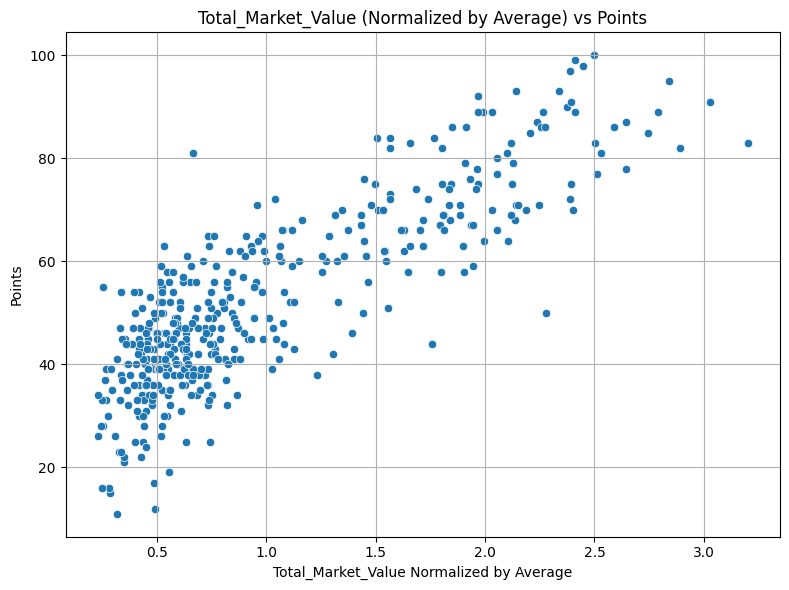

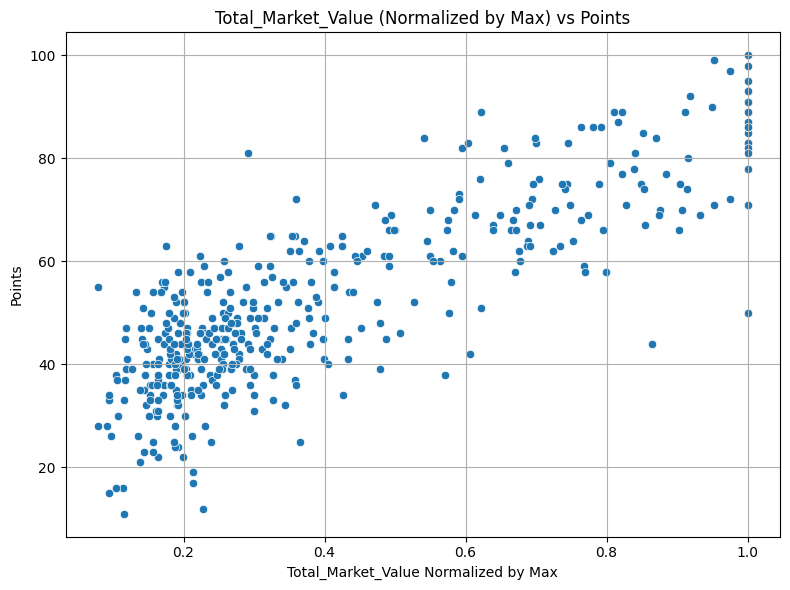

Correlation (Normalized by Avg) vs Points: 0.844
Correlation (Normalized by Max) vs Points: 0.833


In [18]:
# Scatter plot: Normalized by Average
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Total_Market_Value_Normalized_by_Avg'], y=raw_data_excl_25['Points'])
plt.title('Total_Market_Value (Normalized by Average) vs Points')
plt.xlabel('Total_Market_Value Normalized by Average')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot: Normalized by Max
plt.figure(figsize=(8, 6))
sns.scatterplot(x=raw_data_excl_25['Total_Market_Value_Normalized_by_Max'], y=raw_data_excl_25['Points'])
plt.title('Total_Market_Value (Normalized by Max) vs Points')
plt.xlabel('Total_Market_Value Normalized by Max')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

# Pearson correlation: Normalized by Average
corr_avg, p_avg = pearsonr(raw_data_excl_25['Total_Market_Value_Normalized_by_Avg'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Avg) vs Points: {corr_avg:.3f}")

# Pearson correlation: Normalized by Max
corr_max, p_max = pearsonr(raw_data_excl_25['Total_Market_Value_Normalized_by_Max'], raw_data_excl_25['Points'])
print(f"Correlation (Normalized by Max) vs Points: {corr_max:.3f}")

## Summary

#### (1) Squad_Size
- **Description:** The number of players in a particular team's squad for a particular year.  
- **Correlation (without normalization):** 0.062  
- **Correlation (Normalized by Avg) vs Points:** 0.068  
- **Correlation (Normalized by Max) vs Points:** 0.050

#### (2) Average_Age
- **Description:** The average age of all squad players for a particular team's squad for a particular year.  
- **Correlation (without normalization):** -0.354  
- **Correlation (Normalized by Avg) vs Points:** -0.367  
- **Correlation (Normalized by Max) vs Points:** -0.345

#### (3) Number_of_Foreigners
- **Description:** The number of foreign players in a particular team's squad for a particular year.  
- **Correlation (without normalization):** 0.167  
- **Correlation (Normalized by Avg) vs Points:** 0.178  
- **Correlation (Normalized by Max) vs Points:** 0.163

#### (4) Average_Market_Value
- **Description:** The average market value of a team's squad for a particular year.  
- **Correlation (without normalization):** 0.641  
- **Correlation (Normalized by Avg) vs Points:** 0.843  
- **Correlation (Normalized by Max) vs Points:** 0.828

#### (5) Total_Market_Value
- **Description:** The total market value of a team's squad for a particular year.  
- **Correlation (without normalization):** 0.620  
- **Correlation (Normalized by Avg) vs Points:** 0.844  
- **Correlation (Normalized by Max) vs Points:** 0.833

## Step 2 - More Data Analysis

In [19]:
raw_data_excl_25.columns

Index(['Team', 'Squad_Size', 'Average_Age', 'Number_of_Foreigners',
       'Average_Market_Value', 'Total_Market_Value', 'Position',
       'Goal_Difference', 'Points', 'Year', 'Squad_Size_Normalized_by_Avg',
       'Squad_Size_Normalized_by_Max', 'Average_Age_Normalized_by_Avg',
       'Average_Age_Normalized_by_Max',
       'Number_of_Foreigners_Normalized_by_Avg',
       'Number_of_Foreigners_Normalized_by_Max',
       'Average_Market_Value_Normalized_by_Avg',
       'Average_Market_Value_Normalized_by_Max',
       'Total_Market_Value_Normalized_by_Avg',
       'Total_Market_Value_Normalized_by_Max'],
      dtype='object')

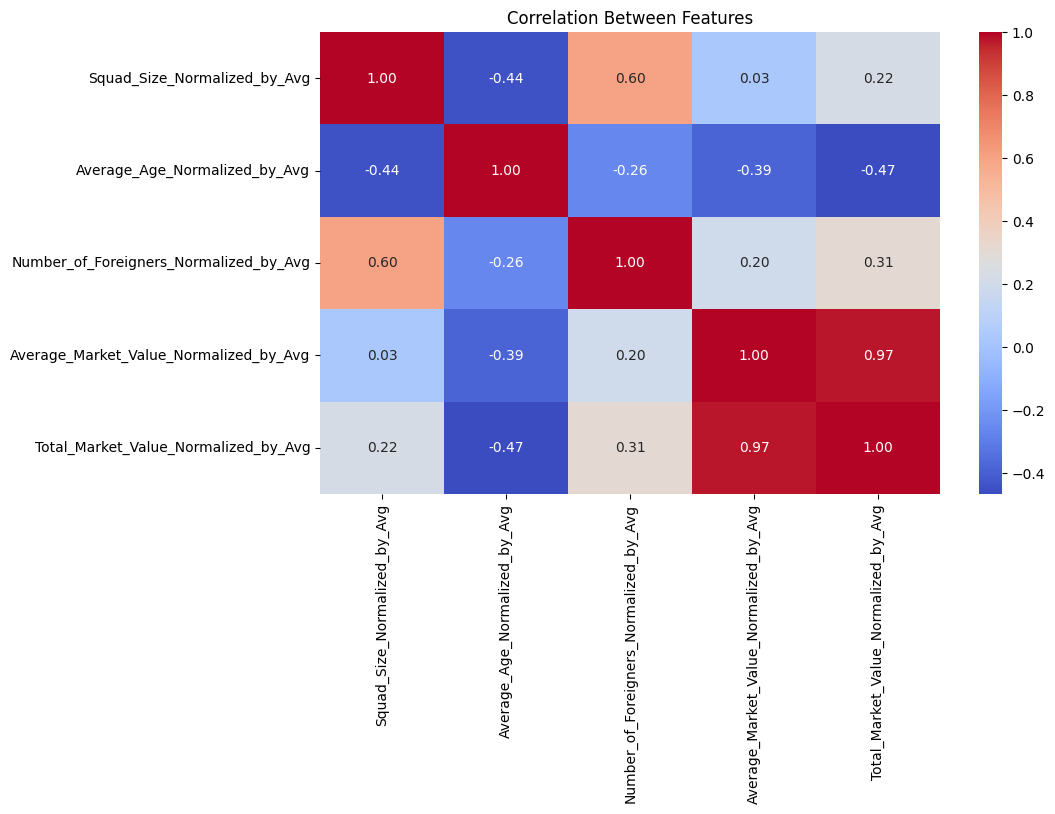

                                  feature        VIF
0            Squad_Size_Normalized_by_Avg   4.538875
1           Average_Age_Normalized_by_Avg   1.532910
2  Number_of_Foreigners_Normalized_by_Avg   1.654482
3  Average_Market_Value_Normalized_by_Avg  72.063937
4    Total_Market_Value_Normalized_by_Avg  76.255622


In [20]:
features = ['Squad_Size_Normalized_by_Avg', 'Average_Age_Normalized_by_Avg', 'Number_of_Foreigners_Normalized_by_Avg', 
            'Average_Market_Value_Normalized_by_Avg', 'Total_Market_Value_Normalized_by_Avg']

X = raw_data_excl_25[features]
y = raw_data_excl_25['Points']

# --- Correlation Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Features")
plt.show()

# --- VIF Calculation ---
X_vif = X.assign(const=1)  # add constant for VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(X_vif.shape[1])]
vif_data = vif_data[vif_data['feature'] != 'const']  # remove constant row
print(vif_data)

In [21]:
X.drop(columns=['Total_Market_Value_Normalized_by_Avg'], inplace=True)


/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/1562725115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Total_Market_Value_Normalized_by_Avg'], inplace=True)


Here, the Variance Inflation Factor, or VIF shows how much the variance of a regression coefficient is inflation due to multicollinearlity. If VIF > 5 or 10 then this means a variable is redundant or can be combined with another. Due to this, Total_Narket_Value_Normalized_By_Average will be dropped.

## Step 3 - Fitting (2) Models!


#### 1. Multiple Linear Regression on Principal Components

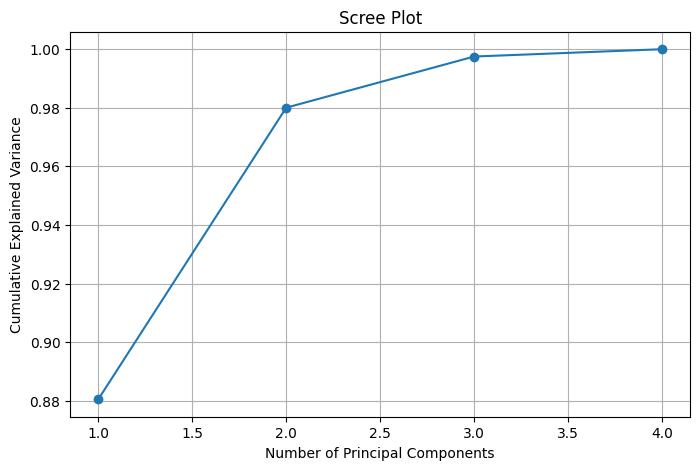

PC1: 0.880 (0.880 cumulative)
PC2: 0.100 (0.980 cumulative)
PC3: 0.017 (0.998 cumulative)
PC4: 0.002 (1.000 cumulative)
R²: 0.665
RMSE: 9.386


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


# -----------------------------------
# 2. Scree Plot (Optional - to pick k)
# -----------------------------------
def plot_scree(X):
    pca = PCA()
    pca.fit(X)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(X.columns) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.show()

    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i+1}: {var:.3f} ({np.cumsum(pca.explained_variance_ratio_)[i]:.3f} cumulative)")

# Uncomment to inspect explained variance
plot_scree(X)

# -----------------------------------
# 3. Build the pipeline
# -----------------------------------
k = 2  # number of PCA components to keep
pca_lr_pipeline = Pipeline([
    ('pca', PCA(n_components=k)),
    ('lr', LinearRegression())
])

# -----------------------------------
# 4. Train-test split
# -----------------------------------
X_train, X_test, y_train_pca, y_test_pca = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------
# 5. Fit the pipeline
# -----------------------------------
pca_lr_pipeline.fit(X_train, y_train_pca)

# -----------------------------------
# 6. Evaluate on test set
# -----------------------------------
y_pred_pca = pca_lr_pipeline.predict(X_test)
r2 = r2_score(y_test_pca, y_pred_pca)
rmse = mean_squared_error(y_test_pca, y_pred_pca, squared=False)

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

This means that our model captures 66.6% of the variation in the data and on average, our predictions are off by 9.386 points per team. For example, if a team got 80 points in a year, our model would predict somewhere between 70-90. This is obviously not good enough but this is our first model so we move.

##### Model 1 - Checking Assumptions

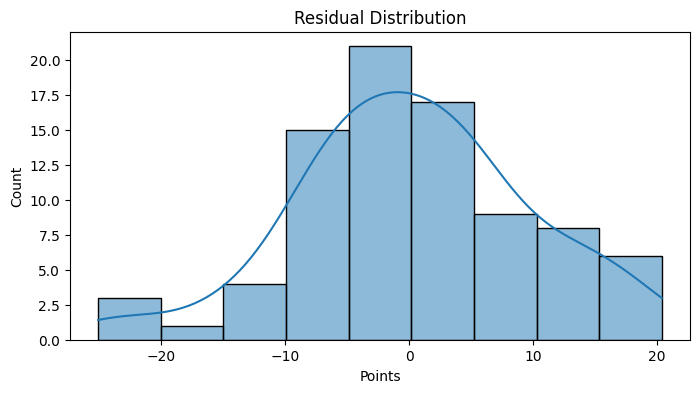

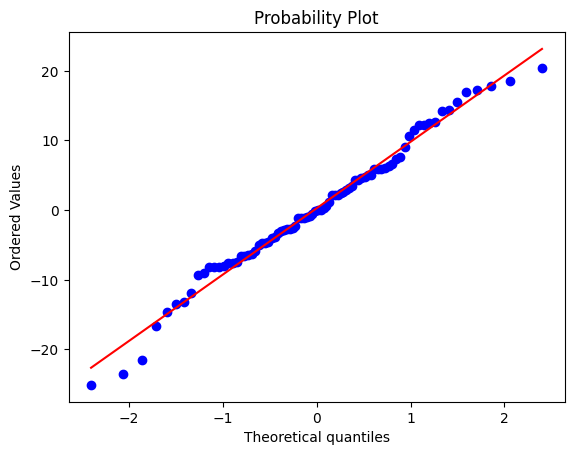

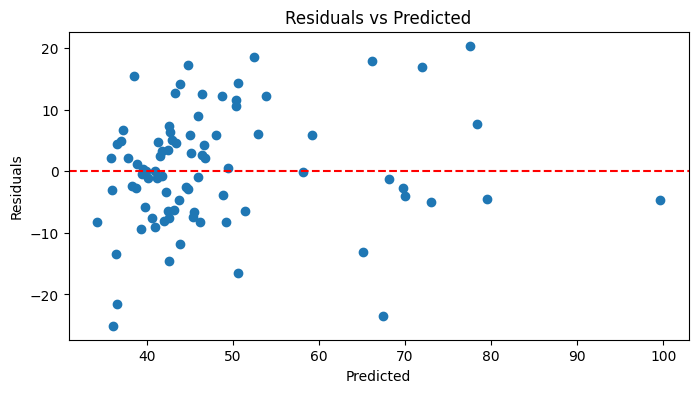

In [23]:
# PCA based Linear Regression Model
residuals_pca = y_test_pca - y_pred_pca

# Histogram of residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals_pca, kde=True)
plt.title("Residual Distribution")
plt.show()

# Q-Q plot
stats.probplot(residuals_pca, dist="norm", plot=plt)
plt.show()

# Residual vs Predicted
plt.figure(figsize=(8, 4))
plt.scatter(y_pred_pca, residuals_pca)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

•	Linearity: Residuals vs Predicted seems normal most points are on the left of the graph...  
•	Normality of residuals: Histogram and Q-Q plot look normal     
•	Homoscedasticity: Looks good

#### 2. Multiple Linear Regression on Predictors

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Original features 
features = ['Squad_Size_Normalized_by_Avg', 'Average_Market_Value_Normalized_by_Avg', 'Number_of_Foreigners_Normalized_by_Avg']

X = raw_data_excl_25[features]
y = raw_data_excl_25['Points']


# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"R² (original features): {r2:.3f}")
print(f"RMSE (original features): {rmse:.3f}")

R² (original features): 0.674
RMSE (original features): 9.209


#### Model 2 - Checking Assumptions

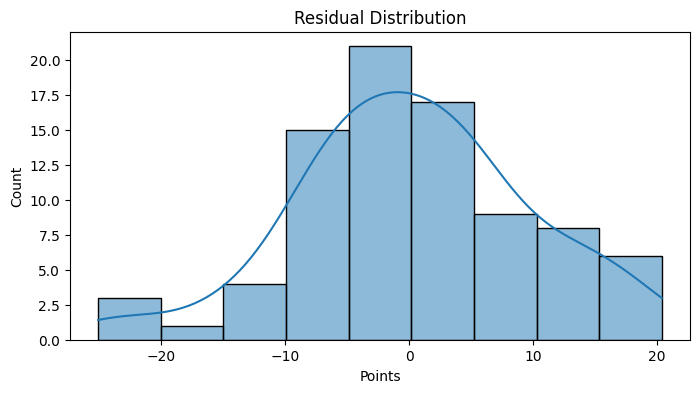

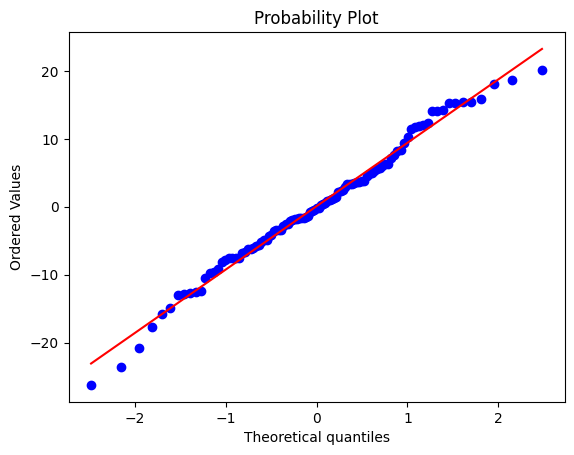

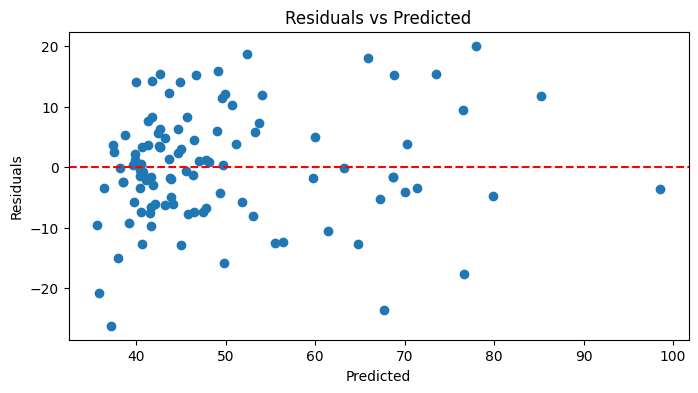

In [25]:
# Feature Based Linear Regression Model
residuals = y_test - y_pred

# Histogram of residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals_pca, kde=True)
plt.title("Residual Distribution")
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

# Residual vs Predicted
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

•	Linearity: Residuals vs Predicted seems normal most points are on the left of the graph...  
•	Normality of residuals: Histogram and Q-Q plot look normal     
•	Homoscedasticity: Looks good

## Step 4 - Lets see what these models output for the 2025-26 season!

In [26]:
# 1. Get raw data only for the 2025-26 season
df_2025 = raw_data[raw_data["Year"] == 2025]

#our features from earlier were
# ['Squad_Size_Normalized_by_Avg', 'Average_Age_Normalized_by_Avg', 'Number_of_Foreigners_Normalized_by_Avg', 'Average_Market_Value_Normalized_by_Avg']

# 2. Apply normalizations since our first models take normalized features. 
avg_per_year = df_2025.groupby('Year')['Squad_Size'].transform('mean')
df_2025['Squad_Size_Normalized_by_Avg'] = df_2025['Squad_Size'] / avg_per_year

avg_per_year = df_2025.groupby('Year')['Average_Age'].transform('mean')
df_2025['Average_Age_Normalized_by_Avg'] = df_2025['Average_Age'] / avg_per_year

avg_per_year = df_2025.groupby('Year')['Number_of_Foreigners'].transform('mean')
df_2025['Number_of_Foreigners_Normalized_by_Avg'] = df_2025['Number_of_Foreigners'] / avg_per_year

avg_per_year = df_2025.groupby('Year')['Average_Market_Value'].transform('mean')
df_2025['Average_Market_Value_Normalized_by_Avg'] = df_2025['Average_Market_Value'] / avg_per_year

/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/2018079410.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025['Squad_Size_Normalized_by_Avg'] = df_2025['Squad_Size'] / avg_per_year
/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/2018079410.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025['Average_Age_Normalized_by_Avg'] = df_2025['Average_Age'] / avg_per_year
/var/folders/dt/n6z_ll3x7g99tg2r0zlz6_8r0000gn/T/ipykernel_97659/2018079410.py:15: SettingWithC

In [27]:
df_2025.columns

Index(['Team', 'Squad_Size', 'Average_Age', 'Number_of_Foreigners',
       'Average_Market_Value', 'Total_Market_Value', 'Position',
       'Goal_Difference', 'Points', 'Year', 'Squad_Size_Normalized_by_Avg',
       'Average_Age_Normalized_by_Avg',
       'Number_of_Foreigners_Normalized_by_Avg',
       'Average_Market_Value_Normalized_by_Avg'],
      dtype='object')

In [28]:
#Inferencing on the PCA Model
pca_model_input = df_2025[['Squad_Size_Normalized_by_Avg', 'Average_Age_Normalized_by_Avg', 'Number_of_Foreigners_Normalized_by_Avg', 'Average_Market_Value_Normalized_by_Avg']]
y_2025_pred = pca_lr_pipeline.predict(pca_model_input)

#Inferencing on the Normal Multiple Linear Regression Model
features_2025 = df_2025[['Squad_Size_Normalized_by_Avg', 'Average_Market_Value_Normalized_by_Avg', 'Number_of_Foreigners_Normalized_by_Avg']]
pred_2025_normal = lr.predict(features_2025)

In [37]:
pred_2025 = pd.DataFrame({
    "PCA_Model_Prediction": y_2025_pred,
    "Normal_Model_Prediction": pred_2025_normal,
    "Team": df_2025["Team"]
})

league_table_pca = pred_2025[["Team", "PCA_Model_Prediction"]]\
    .sort_values(by="PCA_Model_Prediction", ascending=False)\
    .reset_index(drop=True)
league_table_pca.index += 1  # Rank from 1
print("League Table Based on PCA Model Prediction:")
print(league_table_pca)

League Table Based on PCA Model Prediction:
                       Team  PCA_Model_Prediction
1                arsenal fc             83.022892
2           manchester city             77.418203
3              liverpool fc             73.267676
4                chelsea fc             65.125410
5         tottenham hotspur             61.207990
6         manchester united             57.785304
7               aston villa             53.277841
8          newcastle united             52.826425
9         nottingham forest             50.318612
10   brighton & hove albion             47.503387
11           crystal palace             44.868044
12               everton fc             44.494909
13          west ham united             43.977887
14                fulham fc             43.876982
15          afc bournemouth             43.755417
16             brentford fc             42.872716
17  wolverhampton wanderers             42.458111
18             leeds united             41.144101
19    

In [38]:
league_table_normal = pred_2025[["Team", "Normal_Model_Prediction"]]\
    .sort_values(by="Normal_Model_Prediction", ascending=False)\
    .reset_index(drop=True)
league_table_normal.index += 1  # Rank from 1
print("League Table Based on Normal Model Prediction:")
print(league_table_normal)

League Table Based on Normal Model Prediction:
                       Team  Normal_Model_Prediction
1                arsenal fc                83.126325
2           manchester city                77.317946
3              liverpool fc                72.846095
4                chelsea fc                66.125452
5         tottenham hotspur                60.952603
6         manchester united                57.449678
7          newcastle united                54.782416
8               aston villa                52.634600
9         nottingham forest                50.123992
10   brighton & hove albion                47.329651
11           crystal palace                45.648092
12               everton fc                44.879315
13          west ham united                43.781381
14          afc bournemouth                43.446699
15             brentford fc                43.390745
16                fulham fc                42.453344
17  wolverhampton wanderers                41.017323